In [141]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import matplotlib.image as mpimg
from scipy.misc import imresize
import numpy as np
import keras.backend as K
import math
import os
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop

K.clear_session()

img_size=299
train_num = 160
test_num = 36

train_base_dir = './data/v1/train'
test_base_dir = './data/v1/test'

train_not_empty_filenames = os.listdir(train_base_dir + '/0')
train_empty_filenames = os.listdir(train_base_dir + '/1')

test_not_empty_filenames = os.listdir(test_base_dir + '/0')
test_empty_filenames = os.listdir(test_base_dir + '/1')

# print("Train not empty")
# for i, filename in enumerate(train_not_empty_filenames[:2]):
#     print(filename)
#     img = mpimg.imread(train_base_dir + '/0/' + filename)
#     fig, ax = plt.subplots()
#     ax.imshow(img)
#     plt.show()

# print("Train empty")
# for i, filename in enumerate(train_empty_filenames[:2]):
#     print(filename)
#     img = mpimg.imread(train_base_dir + '/1/' + filename)
#     fig, ax = plt.subplots()
#     ax.imshow(img)
#     plt.show()

# print("Test not empty")
# for i, filename in enumerate(test_not_empty_filenames[:2]):
#     print(filename)
#     img = mpimg.imread(test_base_dir + '/0/' + filename)
#     fig, ax = plt.subplots()
#     ax.imshow(img)
#     plt.show()

# print("Test empty")
# for i, filename in enumerate(test_empty_filenames[:2]):
#     print(filename)
#     img = mpimg.imread(test_base_dir + '/1/' + filename)
#     fig, ax = plt.subplots()
#     ax.imshow(img)
#     plt.show()

In [9]:
#Data Augmentation
train_datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        rotation_range = 2,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False,
        zoom_range = 0.1,
        channel_shift_range = 30,
        fill_mode = 'reflect')

#Test data should not be augmented
test_datagen = ImageDataGenerator()

#Load images
def load_images(base_dir, num):
    all_imgs = []
    all_classes = []

    #Load not empty images with label 0
    for i in range(num):
        img_name = base_dir + '/0/'+ str(i + 1) + '.jpg'
        img = mpimg.imread(img_name)
        resize_img = imresize(img, (img_size, img_size))
        all_imgs.append(resize_img)
        all_classes.append(0)
    
    #Load not empty images with label 1
    for i in range(num):
        img_name = base_dir + '/1/'+ str(i + 1) + '.jpg'
        img = mpimg.imread(img_name)
        resize_img = imresize(img, (img_size, img_size))
        all_imgs.append(resize_img)
        all_classes.append(1)
        
    return np.array(all_imgs), np.array(all_classes)

x_train, y_train = load_images(train_base_dir, train_num)
x_test, y_test = load_images(test_base_dir, test_num)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, seed = 13)
test_generator = test_datagen.flow(x_test, y_test, batch_size = 64, seed = 13)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [10]:
#Load Inception v3 model except for the final layer
base_model = InceptionV3(weights = 'imagenet', include_top = False)
#Final layer setting
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, kernel_initializer = "glorot_uniform", activation = "sigmoid", kernel_regularizer = l2(.0005))(x)

model = Model(inputs = base_model.input, outputs = predictions)

#Make the model non-trainable since we won't update the weights of the pre-trained model druing training
for layer in base_model.layers:
    layer.trainable = False

#opt = RMSprop(lr = 0.001)
opt = SGD(lr = 0.01, momentum = 0.9)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['acc'])

checkpointer = ModelCheckpoint(filepath = './model/model_v1.{epoch:02d}-{val_loss:.2f}.hdf5', verbose = 1, save_best_only = True)
csv_logger = CSVLogger('./model/model_v1.log')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2,
                  patience = 5, min_lr = 0.001)

history = model.fit_generator(train_generator,
                    steps_per_epoch = train_num * 2,
                    epochs = 5,
                    validation_data = test_generator,
                    validation_steps = test_num * 2,
                    verbose = 0,
                    callbacks = [reduce_lr, csv_logger, checkpointer])

86745088/87910968 [============================>.] - ETA: 0sEpoch 00000: val_loss improved from inf to 0.50860, saving model to ./model/model_v1.00-0.51.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.50860 to 0.49061, saving model to ./model/model_v1.03-0.49.hdf5
Epoch 00004: val_loss improved from 0.49061 to 0.45855, saving model to ./model/model_v1.04-0.46.hdf5


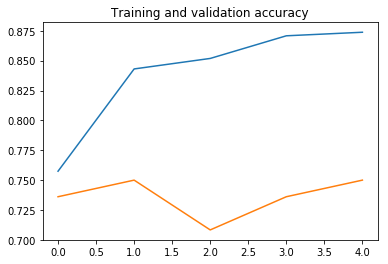

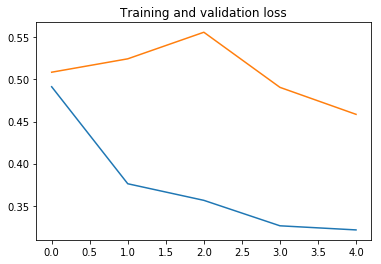

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.show()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.show()

In [20]:
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imresize
import numpy as np

model = load_model(filepath='./model/model_v1.04-0.46.hdf5')

img_size=299

num_test = 32

def predict_img(img_name):
    img = mpimg.imread(img_name)
    fig, ax = plt.subplots()
    ax.imshow(img)
    plt.show()
    
    resize_img = imresize(img, (img_size, img_size))

    x = np.expand_dims(resize_img, axis=0)
    y_pred = model.predict(x)
    
    if y_pred < 0.2:
        print(y_pred[0][0], 'not empty')
    else:
        print(y_pred[0][0], 'empty')

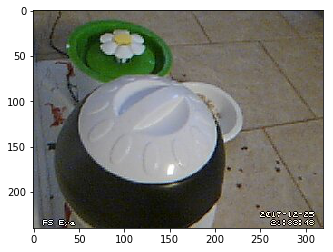

0.456541 empty


In [28]:
predict_img('./data/raw/neko_20171225_153347.jpg')

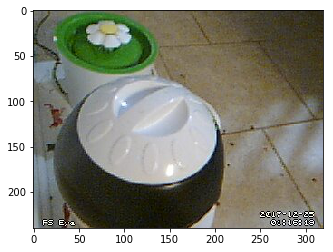

0.160105 not empty


In [4]:
predict_img('./data/v1/test/0/12.jpg')

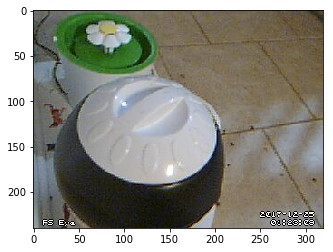

0.687648 empty


In [5]:
predict_img('./data/v1/test/1/12.jpg')

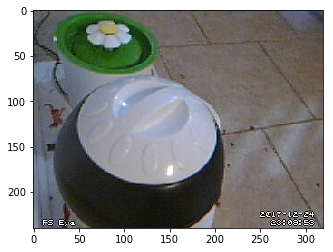

0.175312 not empty


In [10]:
import random

predict_img('./data/v1/test/0/'+str(int(random.random() * num_test + 1))+'.jpg')

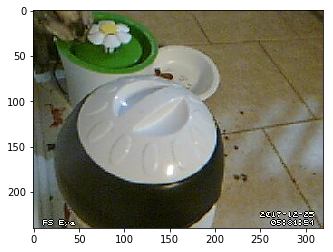

0.257248 empty


In [13]:
import random

predict_img('./data/v1/test/1/'+str(int(random.random() * num_test + 1))+'.jpg')

Score not empty images

In [14]:
true_positive = 0
false_negative = 0

for i in range(num_test):
    img = mpimg.imread('./data/v1/test/0/'+str(i + 1)+'.jpg')
    resize_img = imresize(img, (img_size, img_size))
    
    x = np.expand_dims(resize_img, axis=0)
    y_pred = model.predict(x)
    
    if y_pred < 0.2:
        true_positive = true_positive + 1
    else:
        false_negative = false_negative + 1
        
        #Show the image
        fig, ax = plt.subplots()
        ax.imshow(img)
        print(y_pred)
        #plt.show()

print("True positive: " + str(true_positive))
print("False negative: " + str(false_negative))

[[ 0.41249511]]
[[ 0.37050793]]
[[ 0.45103443]]
[[ 0.28655753]]
[[ 0.25316152]]
[[ 0.32919776]]
[[ 0.36426434]]
True positive: 25
False negative: 7


Score empty images

[[ 0.20235132]]


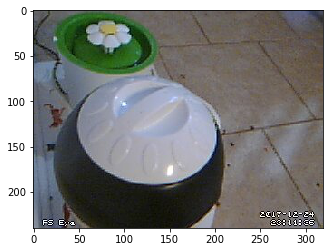

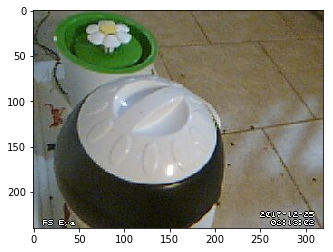

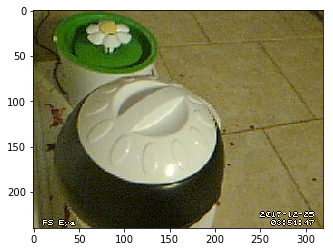

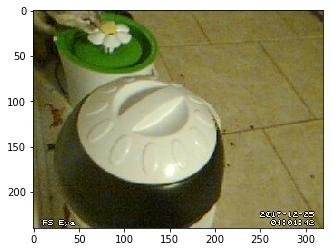

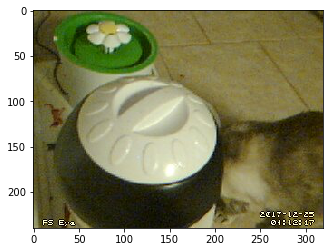

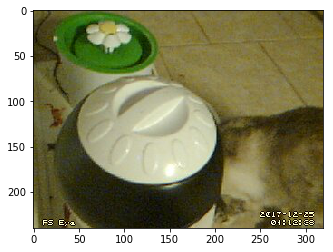

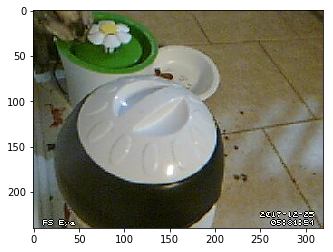

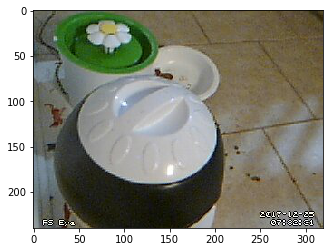

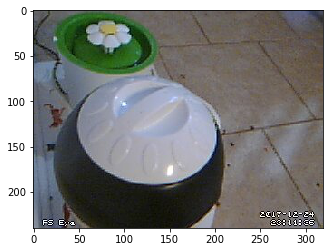

[[ 0.28720328]]


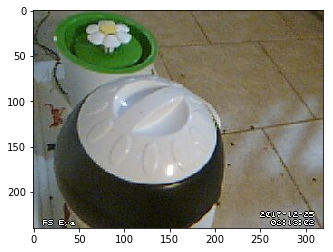

[[ 0.03216524]]


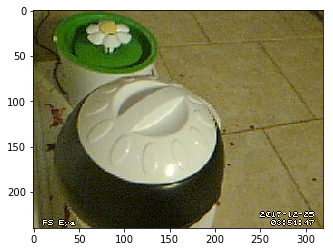

[[ 0.21388197]]


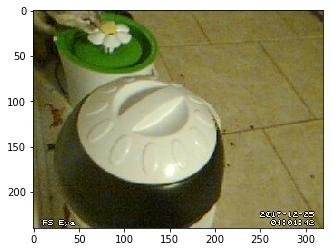

[[ 0.27383763]]


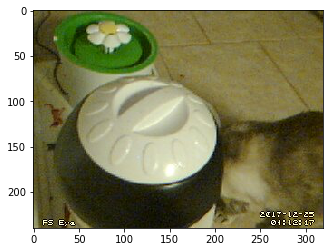

[[ 0.26685265]]


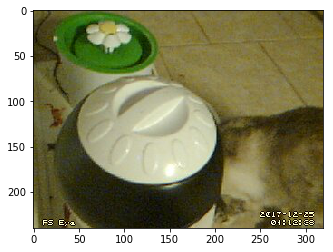

[[ 0.0728225]]


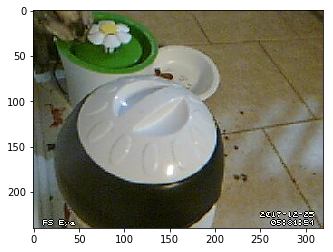

[[ 0.22680451]]


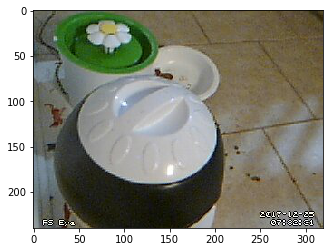

True negative: 24
False positive: 8


In [31]:
true_negative = 0
false_positive = 0

for i in range(num_test):
    img = mpimg.imread('./data/v1/test/1/'+str(i + 1)+'.jpg')
    resize_img = imresize(img, (img_size, img_size))
    
    x = np.expand_dims(resize_img, axis=0)
    y_pred = model.predict(x)
    
    if y_pred < 0.3:
        false_positive = false_positive + 1
        
        #Show the image
        fig, ax = plt.subplots()
        ax.imshow(img)
        print(y_pred)
        plt.show()

    else:
        true_negative = true_negative + 1

print("True negative: " + str(true_negative))
print("False positive: " + str(false_positive))

In [16]:
print("Recall: " + str(true_positive / (true_positive + false_negative)))
print("Precision: " + str(true_positive / (true_positive + false_positive)))

Recall: 0.78125
Precision: 0.9615384615384616


In [17]:
recall_list = []
precision_list = []

for i in range(1, 10):

    confidence = i/10

    true_positive = 0
    false_negative = 0
    true_negative = 0
    false_positive = 0

    for j in range(num_test):
        img = mpimg.imread('./data/v1/test/0/'+str(j + 1)+'.jpg')
        resize_img = imresize(img, (img_size, img_size))

        x = np.expand_dims(resize_img, axis=0)
        y_pred = model.predict(x)

        if y_pred < confidence:
            true_positive = true_positive + 1
        else:
            false_negative = false_negative + 1

        img2 = mpimg.imread('./data/v1/test/1/'+str(j + 1)+'.jpg')
        resize_img2 = imresize(img2, (img_size, img_size))

        x2 = np.expand_dims(resize_img2, axis=0)
        y_pred2 = model.predict(x2)

        if y_pred2 < confidence:
            false_positive = false_positive + 1
        else:
            true_negative = true_negative + 1

    recall_list.append(true_positive / (true_positive + false_negative))
    precision_list.append(true_positive / (true_positive + false_positive))

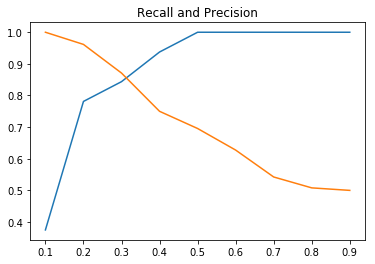

In [19]:
confidence_level = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.plot(confidence_level, recall_list)
plt.plot(confidence_level, precision_list)
plt.title('Recall and Precision')
plt.show()